In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
import os
dir = '/content/drive/MyDrive/SINGAN'
os.chdir(dir)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 44 * 60, 1),  # Input is downsampled to 44 x 60
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        # Define your architecture here. For example, a simple autoencoder-like architecture.
        self.encoder = nn.Sequential(
            nn.Conv2d(1 + noise_dim, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Assuming masks have values between 0 and 1
        )

    def forward(self, x, noise):
        x = torch.cat([x, noise], dim=1)  # Concatenating the noise along channel dimension
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class Generator2(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Define your architecture here. For example, a simple autoencoder-like architecture.
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Assuming masks have values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class Scorer(nn.Module):
    def __init__(self):
        super(Scorer, self).__init__()
        # Define your architecture here
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = self.features(x)
        x = torch.mean(x, dim=[2, 3])
        x = self.fc(x)
        return x

import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
class TopologicalLoss(nn.Module):
    def __init__(self):
        super(TopologicalLoss, self).__init__()
        self.kernel1 = torch.tensor([ [1, 1, 1],
                                      [1, 0, 1],
                                      [1, 1, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        self.kernel01 = torch.tensor([[1, 1, 1],
                                      [0, 0, 1],
                                      [1, 1, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        self.kernel02 = torch.tensor([[1, 1, 1],
                                      [1, 0, 1],
                                      [1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        self.kernel03 = torch.tensor([[1, 1, 1],
                                      [1, 0, 0],
                                      [1, 1, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        self.kernel04 = torch.tensor([[1, 0, 1],
                                      [1, 0, 1],
                                      [1, 1, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        self.kernel05 = torch.tensor([[0, 1, 1],
                                      [1, 0, 1],
                                      [1, 1, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        self.kernel06 = torch.tensor([[1, 1, 1],
                                      [1, 0, 1],
                                      [0, 1, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        self.kernel07 = torch.tensor([[1, 1, 1],
                                      [1, 0, 1],
                                      [1, 1, 0]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        self.kernel08 = torch.tensor([[1, 1, 0],
                                      [1, 0, 1],
                                      [1, 1, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)


        self.kernel20 = torch.tensor([[1, 1, 1, 1, 1],
                                     [1, 0, 0, 0, 1],
                                     [1, 0, 0, 0, 1],
                                     [1, 0, 0, 0, 1],
                                     [1, 1, 1, 1, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        self.kernel21 = torch.tensor([[0, 0, 0, 1, 1],
                                      [0, 0, 0, 0, 1],
                                      [0, 0, 0, 0, 1],
                                      [1, 0, 0, 0, 1],
                                     [ 1, 1, 1, 1, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        self.kernel22 = torch.tensor([[1, 1, 0, 0, 0],
                                     [1, 0, 0, 0, 0],
                                     [1, 0, 0, 0, 0],
                                     [1, 0, 0, 0, 1],
                                     [1, 1, 1, 1, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        self.kernel23 = torch.tensor([[1, 1, 1, 1, 1],
                                     [1, 0, 0, 0, 1],
                                     [1, 0, 0, 0, 0],
                                     [1, 0, 0, 0, 0],
                                     [1, 1, 0, 0, 0]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        self.kernel24 = torch.tensor([[1, 1, 1, 1, 1],
                                     [1, 0, 0, 0, 1],
                                     [0, 0, 0, 0, 1],
                                     [0, 0, 0, 0, 1],
                                     [0, 0, 0, 1, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        self.kernel3 = torch.Tensor(  [[0, 0, 1, 1],
                       [0, 0, 0, 1],
                       [1, 0, 0, 1],
                       [1, 1, 1, 1]]).view(1,1,4,4)

        self.kernel4 = torch.Tensor(  [[1, 1, 0, 0],
                              [1, 0, 0, 0],
                              [1, 0, 0, 1],
                              [1, 1, 1, 1]]).view(1,1,4,4)

        self.kernel5 = torch.Tensor(  [[1, 1, 1, 1],
                              [1, 0, 0, 1],
                              [0, 0, 0, 1],
                              [0, 0, 1, 1]]).view(1,1,4,4)

        self.kernel6 = torch.Tensor(  [[1, 1, 1, 1],
                              [1, 0, 0, 1],
                              [1, 0, 0, 0],
                              [1, 1, 0, 0]]).view(1,1,4,4)

        self.kernel7 = torch.Tensor(  [[1, 0, 0, 1],
                              [1, 0, 0, 1],
                              [1, 0, 0, 1],
                              [1, 1, 1, 1]]).view(1,1,4,4)

        self.kernel8 = torch.Tensor(  [[1, 1, 1, 1],
                              [0, 0, 0, 1],
                              [0, 0, 0, 1],
                              [1, 1, 1, 1]]).view(1,1,4,4)

        self.kernel9 = torch.Tensor(  [[1, 1, 1, 1],
                              [1, 0, 0, 1],
                              [1, 0, 0, 1],
                              [1, 0, 0, 1]]).view(1,1,4,4)

        self.kernel10 = torch.Tensor(  [[1, 1, 1, 1],
                              [1, 0, 0, 0],
                              [1, 0, 0, 0],
                              [1, 1, 1, 1]]).view(1,1,4,4)
        self.kernels = [self.kernel01, self.kernel02, self.kernel03, self.kernel04, self.kernel05, self.kernel06, self.kernel07, self.kernel08, self.kernel1, self.kernel20, self.kernel21, self.kernel22, self.kernel23, self.kernel24, self.kernel3, self.kernel4,self.kernel5, self.kernel6, self.kernel7,self.kernel8, self.kernel9, self.kernel10]

    def soft_threshold(self, x, threshold, alpha=10.0):
        return torch.sigmoid(alpha * (-x + threshold))

    def endpoints(self, mask, kernel, padded=True):
        kernel_size = kernel.shape[-1]
        pad = 2
        if kernel_size == 3:
            pad = 1
        elif kernel_size == 5:
            pad = 2
        neighbors_count = F.conv2d(mask, kernel, padding=pad)
        if kernel_size == 4:
          line_ends = self.soft_threshold(neighbors_count[:,:,:-1, :-1], 1.0) * mask
        else:
          line_ends = self.soft_threshold(neighbors_count, 1.0) * mask
        if padded:
          line_ends = line_ends[:, :, 1:-1, 1:-1]
        return line_ends

    def forward(self, mask):
        epss = torch.zeros_like(mask)
        i=1
        for kernel in self.kernels:
#           if i in [2,3,4,5,6,7,8,9]:
            if mask.is_cuda:
                kernel = kernel.cuda()
            padding = (1, 1, 1, 1)
            padded_mask = F.pad(mask[0], padding, 'constant', 1)
            eps = self.endpoints(padded_mask.unsqueeze(0), kernel = kernel, padded=True)
            epss += eps
#           i+=1
        loss = (epss[0]/8).sum()
        return loss


class CustSigmoid(nn.Module):
    def __init__(self, alpha=55, beta=0.5):
        super(CustSigmoid, self).__init__()
        self.alpha = alpha
        self.beta = beta
    def forward(self, x):
        return 1 / (1 + torch.exp(-self.alpha * (x + self.beta)))
import torch
import torch.nn.functional as F
import torch.nn as nn

class HistogramLoss(nn.Module):
    def __init__(self, num_bins=50, min_val=None, max_val=None):
        super(HistogramLoss, self).__init__()
        self.num_bins = num_bins
        self.min_val = min_val
        self.max_val = max_val

    def forward(self, input_img, target_img):
        min_val = self.min_val
        max_val = self.max_val
        if min_val is None:
            min_val = torch.min(input_img).item()
        if max_val is None:
            max_val = torch.max(input_img).item()
        bin_edges = torch.linspace(min_val, max_val, self.num_bins + 1).to(device)
        bin_centers = (bin_edges[:-1].clone().to(device) + bin_edges[1:].clone().to(device)) / 2

        def compute_histogram(image):
            exp_terms = (bin_centers.view(1, -1) - image.view(-1, 1)) ** 2
            exp_terms *= -0.5
            hist_values = torch.exp(exp_terms)
            histogram = torch.sum(hist_values, dim=0)
            return histogram
        input_hist = compute_histogram(input_img)
        target_hist = compute_histogram(target_img)
#         loss = torch.sum((input_hist - target_hist) ** 2)
        loss = torch.nn.MSELoss()(input_hist,target_hist)
        return torch.sqrt(loss)



In [7]:

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from skimage.io import imshow, imread, imsave
# from models import Generator, TopologicalLoss, CustSigmoid, Discriminator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
histogram_loss = HistogramLoss().to(device)
sig = CustSigmoid().to(device)
scorer = TopologicalLoss().to(device)
# Loss = nn.BCEWithLogitsLoss()
Loss = nn.BCELoss().to(device)
# Loss = nn.MSELoss()
noise_dim = 10
generator = Generator(noise_dim=noise_dim).to(device)
optimizer_g = optim.Adam(generator.parameters(), lr=0.0001)
sig2 = CustSigmoid(55, -0.5).to(device)
def train(input_mask, latent_noise, alpha=1, beta=10):
    num_iterations = 2000
    for epoch in range(num_iterations):
        enhanced_mask = generator(input_mask, latent_noise)
        g_loss = Loss(enhanced_mask[:, :, :-1, :], input_mask)
        hist_loss = histogram_loss(enhanced_mask, input_mask)

        # if epoch == 10000:
        #     combined_loss.detach()
        # if epoch > 0:
        scorer_loss = scorer(sig2(enhanced_mask.to(device)))
        # else:
        #     scorer_loss=torch.tensor(0)
#         combined_loss = beta*scorer_loss + hist_loss
        combined_loss = 18*hist_loss + 100*g_loss #+ 2*scorer_loss
        optimizer_g.zero_grad()
        combined_loss.backward(retain_graph=True)
        optimizer_g.step()
#         combined_loss.detach()
        if epoch % 100 == 0:
            print(f"Iteration {epoch}, g_loss: {g_loss.item()}, Scorer Loss: {scorer_loss.item()}", 'hist: ', hist_loss)

    final_enhanced_mask = generator(input_mask, latent_noise)
    return final_enhanced_mask

input_mask = torch.load('fake_xx_8_old.pth').to(device)
input_mask = sig(input_mask)

latent_noise = torch.randn(1, noise_dim, input_mask.size()[2], input_mask.size()[3]).to(device)
enhanced_mask = train(input_mask, latent_noise)



Iteration 0, g_loss: 0.7800515294075012, Scorer Loss: 2.7818236048915423e-05 hist:  tensor(5540.0923, device='cuda:0', grad_fn=<SqrtBackward0>)
Iteration 100, g_loss: 1.3712555170059204, Scorer Loss: 4875.4716796875 hist:  tensor(2150.2122, device='cuda:0', grad_fn=<SqrtBackward0>)
Iteration 200, g_loss: 2.574354410171509, Scorer Loss: 8201.322265625 hist:  tensor(496.2286, device='cuda:0', grad_fn=<SqrtBackward0>)
Iteration 300, g_loss: 3.083388090133667, Scorer Loss: 8232.0146484375 hist:  tensor(379.9215, device='cuda:0', grad_fn=<SqrtBackward0>)
Iteration 400, g_loss: 3.2883522510528564, Scorer Loss: 8232.0146484375 hist:  tensor(368.9631, device='cuda:0', grad_fn=<SqrtBackward0>)
Iteration 500, g_loss: 3.379183769226074, Scorer Loss: 8232.0146484375 hist:  tensor(365.0773, device='cuda:0', grad_fn=<SqrtBackward0>)
Iteration 600, g_loss: 3.4150304794311523, Scorer Loss: 8232.0146484375 hist:  tensor(363.2212, device='cuda:0', grad_fn=<SqrtBackward0>)
Iteration 700, g_loss: 3.432031

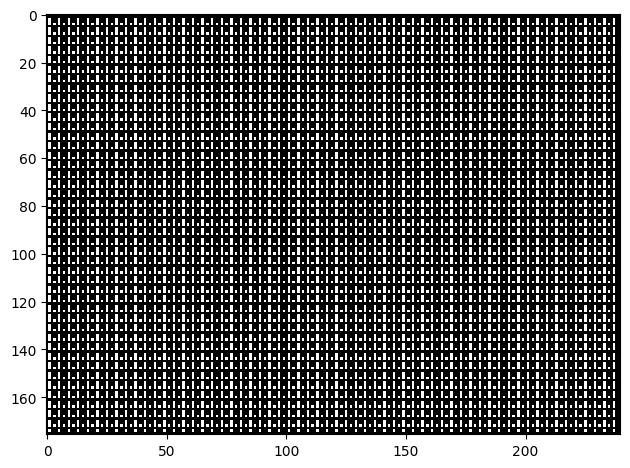

In [8]:
imshow(enhanced_mask[0][0].detach().cpu().numpy())

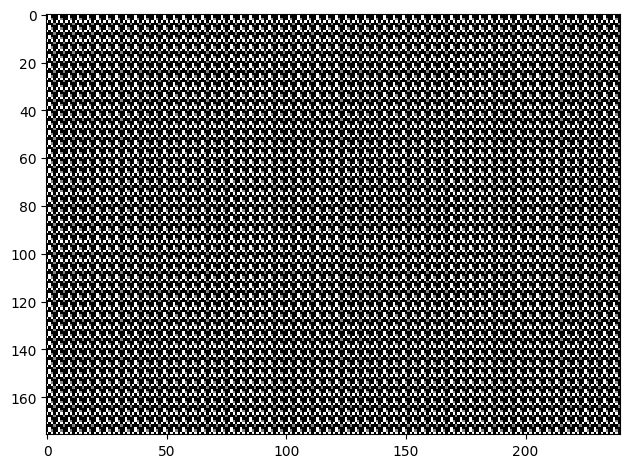

In [6]:
imshow(enhanced_mask[0][0].detach().cpu().numpy())
